<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/2_ML_workflow_class_balanced_average_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [23]:
# remove library not used
import pandas as pd
import numpy as np
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from matplotlib.pyplot import figure
import copy
from tqdm import tqdm
import seaborn as sns
from datetime import datetime

# packages for data_preparation pipeline
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score, average_precision_score
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

# packages for classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# packages for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# packages for loading and dumping models
from google.colab import drive, files
import os
from joblib import dump, load

# packages for ensemble learning
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

In [2]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

# Read train set

In [3]:
train_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_train_comprehensive.pkl?raw=true")
train_set

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OFF_RATING,DEF_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,PACE,PACE_PER40,POSS,PIE,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,111.6,98.7,12.9,0.640,1.94,19.0,0.362,0.671,0.518,0.143,0.508,0.543,91.56,76.30,4403,0.592,21.4,17.9,13.9,39.1,14.9,15.7,11.1,41.7,0.264,0.467,0.259,0.178,0.329,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.611,0.389,0.793,0.207,0.640,0.360,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,1,1996-97,1610612741199697
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,105.4,99.5,5.9,0.527,1.21,14.7,0.336,0.667,0.506,0.167,0.490,0.534,87.65,73.04,4066,0.533,18.3,15.4,8.5,37.8,18.4,16.5,12.9,41.6,0.303,0.466,0.236,0.168,0.333,0.716,0.284,0.555,0.196,0.254,0.081,0.190,0.174,0.359,0.473,0.527,0.702,0.298,0.527,0.473,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,0,1996-97,1610612737199697
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,10,Minnesota Timberwolves,102.9,105.1,-2.2,0.613,1.39,16.7,0.333,0.641,0.487,0.168,0.475,0.525,92.17,76.81,4445,0.495,19.4,15.3,10.6,38.4,18.3,14.8,14.0,44.3,0.343,0.488,0.339,0.177,0.359,0.838,0.162,0.648,0.274,0.138,0.103,0.214,0.189,0.374,0.608,0.392,0.643,0.357,0.613,0.387,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,0,1996-97,1610612750199697
4,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,108.4,100.9,7.4,0.695,1.66,19.9,0.311,0.687,0.508,0.170,0.516,0.563,90.74,75.62,4305,0.571,20.4,12.8,14.3,45.9,17.7,14.0,9.0,37.1,0.360,0.474,0.381,0.179,0.313,0.853,0.147,0.668,0.244,0.122,0.132,0.209,0.188,0.424,0.688,0.312,0.747,0.253,0.695,0.305,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,0,1996-97,1610612762199697
5,1610612761,Toronto Raptors,46,17,29,0.370,52.3,36.9,86.0,0.429,8.1,22.0,0.366,19.3,26.3,0.734,14.4,30.4,44.9,21.8,18.6,9.0,6.8,6.2,25.7,0.1,101.1,-3.9,10,Toronto Raptors,101.1,105.3,-4.2,0.591,1.17,15.7,0.349,0.644,0.494,0.186,0.476,0.518,91.58,76.32,4256,0.466,18.7,15.5,18.9,42.0,20.9,16.4,20.4,45.6,0.305,0.490,0.359,0.179,0.356,0.744,0.256,0.570,0.155,0.239,0.187,0.191,0.185,0.415,0.551,0.449,0.735,0.265,0.591,0.409,38.4,84.8,0.453,6.4,18.6,0.344,21.9,30.5,0.717,14.9,30.4,45.3,25.0,17.9,9.3,6.2,6.8,24.1,25.7,105.1,0,1996-97,1610612761199697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,1610612742,Dalla

# Exploratory data analysis
- dataset set can be split into left and right half
- features = team stats
- Y = PLAYOFF_RANKING

In [4]:
pd.DataFrame(train_set.dtypes).T

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OFF_RATING,DEF_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,PACE,PACE_PER40,POSS,PIE,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,object,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category,category,object


In [5]:
train_set.describe()

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,PACE,PACE_PER40,POSS,PIE,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.00000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,51.010545,25.277680,25.732865,0.496369,50.807206,39.177329,86.874692,0.451037,7.821793,22.021441,0.353483,18.958875,25.093322,0.756631,11.728295,33.116872,44.847979,23.043058,15.413005,7.991037,5.185237,5.230228,22.212478,15.284007,105.135149,-0.076626,105.133743,105.211599,-0.074692,0.58800,1.512091,16.755009,0.297603,0.702086,0.499865,0.154130,0.496014,0.537004,94.622478,78.852144,4866.086116,0.498974,17.250615,13.905975,13.334622,43.298594,17.288225,13.881547,13.403866,43.313005,0.289515,0.496197,0.290399,0.153956,0.297916,0.746938,0.253062,0.598081,0.186262,0.221269,0.126942,0.180673,0.164359,0.411830,0.523838,0.476162,0.844703,0.155297,0.588004,0.411998,39.201406,86.840949,0.451424,7.789807,21.911248,0.354608,19.020914,25.149385,0.756891,11.723902,33.162039,44.885062,23.072056,15.396309,8.030053,5.230228,5.185062,22.212654,22.212302,105.210896
std,6.095186,8.485709,8.734483,0.156774,1.984864,1.600593,2.162189,0.016853,2.799355,7.499584,0.022351,2.241564,3.087593,0.031409,1.742587,1.741487,1.900621,1.989176,1.479605,0.962066,0.953049,0.802286,2.285226,9.772402,4.505587,4.928410,4.506723,4.214692,4.869406,0.04237,0.220496,1.272521,0.030621,0.024939,0.013844,0.014796,0.026870,0.024131,3.746042,3.121345,645.508336,0.034493,1.679832,1.639091,2.813645,4.360453,1.659327,1.282710,1.851004,3.781833,0.040336,0.025211,0.041296,0.014698,0.024942,0.084756,0.084756,0.059093,0.066083,0.072373,0.026631,0.022793,0.017398,0.037643,0.053763,0.053763,0.051501,0.051501,0.042370,0.042370,1.665716,2.179512,0.015978,2.519110,6.838016,0.017344,2.278359,3.089858,0.017929,1.423640,1.716470,1.677032,1.701204,1.472974,0.786658,0.802286,0.953130,2.152614,2.285038,4.242191
min,30.000000,4.000000,4.000000,0.077000,45.500000,34.100000,81.000000,0.407000,2.400000,7.800000,0.279000,12.900000,17.900000,0.647000,7.500000,27.700000,37.600000,18.200000,11.100000,5.700000,2.400000,3.100000,16.900000,0.000000,89.500000,-15.500000,89.500000,91.800000,-15.700000,0.47200,1.000000,13.800000,0.215000,0.634000,0.460000,0.111000,0.425000,0.466000,84.640000,70.540000,2837.000000,0.404000,12.800000,9.000000,6.400000,32.200000,12.200000,10.000000,6.800000,31.900000,0.196000,0.426000,0.204000,0.116000,0.228000,0.484000,0.0

In [6]:
# explanatory variable (Y) = PLAYOFF_RANKING
# for some seasons, we don't have a champion becuz of train-test split
train_set.groupby(["SEASON"]).PLAYOFF_RANKING.value_counts().reset_index().pivot(index = "level_1", columns = "SEASON", values = "PLAYOFF_RANKING")

SEASON,1996-97,1999-00,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22
level_1,,,,,,,,,,,,,,,,,,,,,,,,
0,24,22,23,25,22,23,24,22,22,23,20,21,23,23,21,23,26,24,23,21,23,24,25,23
1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1


In [7]:
# no missing data
train_set.isna().sum()[train_set.isna().sum() != 0]

Series([], dtype: int64)

In [8]:
numeric_col = train_set.select_dtypes(include=np.number).columns.values.tolist()
print(f"number of numeric columns: {len(numeric_col)}")

number of numeric columns: 90


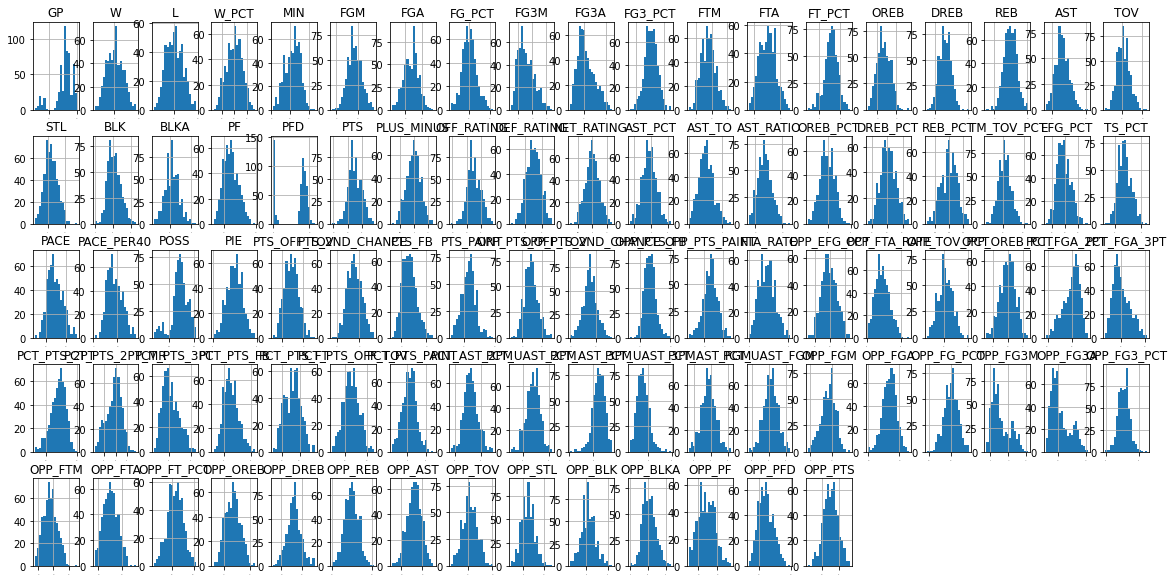

In [9]:
# plot distributions of each numeric column
train_set.hist(bins=20, layout = (5, int(len(numeric_col) / 5) + 1), figsize= (20,10), xlabelsize=0)
plt.show()

## Class imbalance in y

In [10]:
# only 3% of data in positive class (winning a championship)
train_set.PLAYOFF_RANKING.value_counts(normalize=True)*100

0    96.660808
1     3.339192
Name: PLAYOFF_RANKING, dtype: float64

## Outliers in PFD - to be fixed in num_pipeline

In [11]:
# equivalent measure: PFD (# of fouls drawn) = OPP_PF (# of fouls committed by opponent)
# outlier: PFD (Personal Fouls Drawn) with a high frequency at 0 
train_set.PFD.value_counts(bins = np.linspace(train_set.PFD.min(), train_set.PFD.max(), 10, dtype=int)).sort_index()

(-0.001, 3.0]    163
(3.0, 6.0]         5
(6.0, 9.0]         0
(9.0, 12.0]        0
(12.0, 15.0]       0
(15.0, 19.0]      39
(19.0, 22.0]     215
(22.0, 25.0]     132
(25.0, 28.0]      14
Name: PFD, dtype: int64

In [12]:
# while OPP_PF (ie PFD) has a more even distribution
# consider replacing PFD with OPP_PF
train_set.OPP_PF.value_counts(bins = np.linspace(train_set.OPP_PF.min(), train_set.OPP_PF.max(), 10, dtype=int)).sort_index()

(16.999, 18.0]      8
(18.0, 20.0]       87
(20.0, 21.0]       96
(21.0, 22.0]       87
(22.0, 23.0]       86
(23.0, 24.0]       84
(24.0, 26.0]      100
(26.0, 27.0]       13
(27.0, 28.0]        6
Name: OPP_PF, dtype: int64

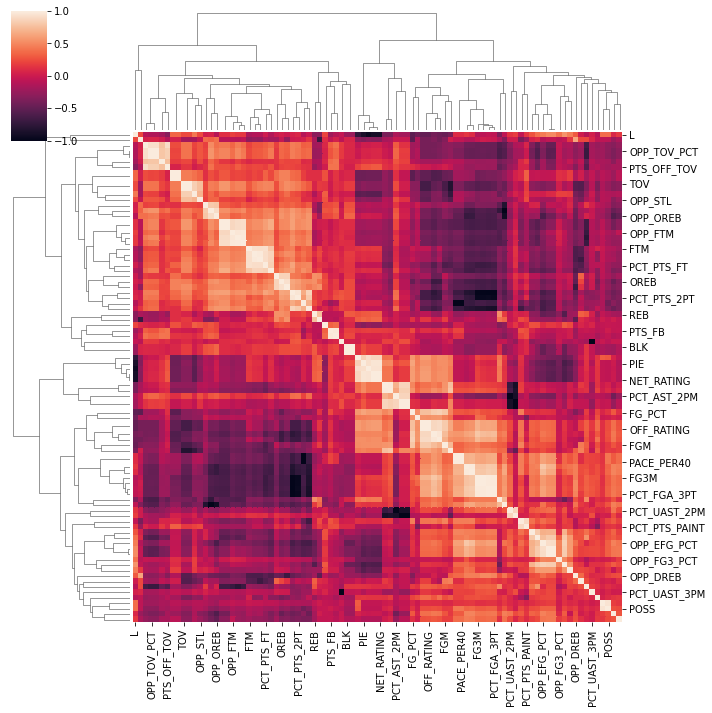

In [13]:
corr_mat = train_set.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(corr_mat, 
#             annot=False, 
#             vmin=-1,
#             vmax=1,
#             mask = np.triu(corr_mat)) # to show only lower triangle
# plt.show()

# use dendrogram to see clusters
# offense and defensive stats tend to cluster with each other
sns.clustermap(corr_mat)

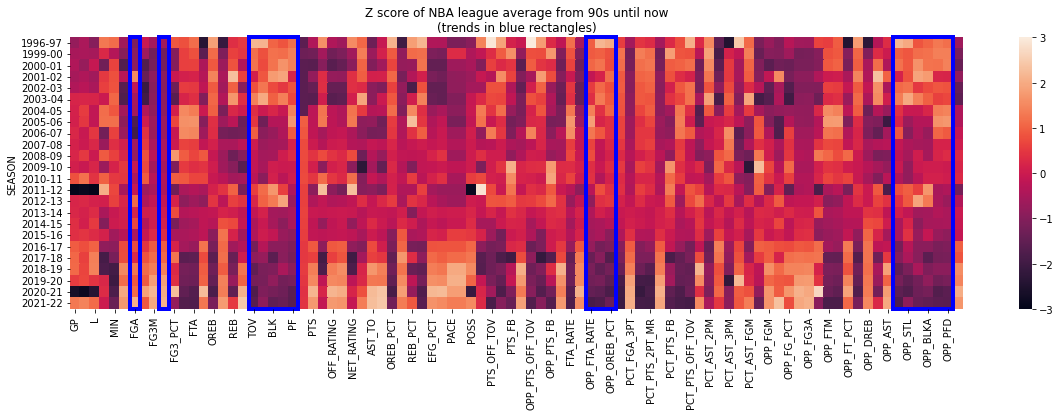

In [14]:
# it's often mentioned that NBA teams in different era play with different styles
# we have already adjusted the stats per possession so pace doesn't impact the numbers here
# in 90s, teams tend to focus more on defense and are more physical (higher PF, BLK, STL, TOV)
# in recent era, teams shoot more 3s and score more points (FG and FG3)
# Feature engineering: clustering for SEASON to take into account this difference 
ax = sns.heatmap(train_set.loc[:,numeric_col + ["SEASON"]].groupby("SEASON").mean().apply(zscore),
                 vmin=-3, vmax=3)
plt.title("Z score of NBA league average from 90s until now\n(trends in blue rectangles)")
for col in [
    ("FGA"), ("FG3A"), ("TOV", "STL", "BLK", "BLKA", "PF"),
    ('OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT'),
    ('OPP_TOV', 'OPP_STL', 'OPP_BLK', 'OPP_BLKA', 'OPP_PF', 'OPP_PFD')
    ]:
  if type(col) is not str:
    ax.add_patch(Rectangle((numeric_col.index(col[0]), 0), len(col), len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
  else:
    ax.add_patch(Rectangle((numeric_col.index(col), 0), 1, len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
plt.show()

# Data preparation
- Over/Under-sampling to reduce imbalance in data
  - data set is highly imbalanced with only 1 out of 30 NBA teams winning the championship each year
  - however, over-sampling the champions may exacerbate the bias in our small sample
  - there is not enough data to under-sample as well
  - therefore let's keep it as is and use confusion matrix to measure performance accordingly
- Data cleaning
  - Transformations done at dataset level so not included in pipeline
    - Drop irrelevant columns, e.g. GP (Games Played) is 82 for most seasons and stats are already normalized per 100 possessions
    - Remove outlier seasons in terms of GP (Games Played)
  - Fix PFD column with OPP_PF column
  - Feature scaling
    - Transform numeric variables by normal quantiles 
  
- Feature engineering
  - Cluster similar seasons together with KMeans to represent different NBA eras

- Dimensionality reduction
  - PCA to speed up random forest and fix axis orientation issue with decision tree

- Feature selection
  - Use random forest to drop useless features

## *add pythagorean expectation

In [15]:
# make a copy and split X and y
season = train_set.drop(columns = "PLAYOFF_RANKING").reset_index(drop = True).copy(deep = True)
season_label = train_set[["PLAYOFF_RANKING"]].values.reshape(-1,)

In [16]:
# X_train before data preparation
season

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OFF_RATING,DEF_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,PACE,PACE_PER40,POSS,PIE,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,SEASON,UNIQUE_ID
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,111.6,98.7,12.9,0.640,1.94,19.0,0.362,0.671,0.518,0.143,0.508,0.543,91.56,76.30,4403,0.592,21.4,17.9,13.9,39.1,14.9,15.7,11.1,41.7,0.264,0.467,0.259,0.178,0.329,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.611,0.389,0.793,0.207,0.640,0.360,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,1996-97,1610612741199697
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,105.4,99.5,5.9,0.527,1.21,14.7,0.336,0.667,0.506,0.167,0.490,0.534,87.65,73.04,4066,0.533,18.3,15.4,8.5,37.8,18.4,16.5,12.9,41.6,0.303,0.466,0.236,0.168,0.333,0.716,0.284,0.555,0.196,0.254,0.081,0.190,0.174,0.359,0.473,0.527,0.702,0.298,0.527,0.473,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,1996-97,1610612737199697
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,10,Minnesota Timberwolves,102.9,105.1,-2.2,0.613,1.39,16.7,0.333,0.641,0.487,0.168,0.475,0.525,92.17,76.81,4445,0.495,19.4,15.3,10.6,38.4,18.3,14.8,14.0,44.3,0.343,0.488,0.339,0.177,0.359,0.838,0.162,0.648,0.274,0.138,0.103,0.214,0.189,0.374,0.608,0.392,0.643,0.357,0.613,0.387,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,1996-97,1610612750199697
3,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,108.4,100.9,7.4,0.695,1.66,19.9,0.311,0.687,0.508,0.170,0.516,0.563,90.74,75.62,4305,0.571,20.4,12.8,14.3,45.9,17.7,14.0,9.0,37.1,0.360,0.474,0.381,0.179,0.313,0.853,0.147,0.668,0.244,0.122,0.132,0.209,0.188,0.424,0.688,0.312,0.747,0.253,0.695,0.305,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,1996-97,1610612762199697
4,1610612761,Toronto Raptors,46,17,29,0.370,52.3,36.9,86.0,0.429,8.1,22.0,0.366,19.3,26.3,0.734,14.4,30.4,44.9,21.8,18.6,9.0,6.8,6.2,25.7,0.1,101.1,-3.9,10,Toronto Raptors,101.1,105.3,-4.2,0.591,1.17,15.7,0.349,0.644,0.494,0.186,0.476,0.518,91.58,76.32,4256,0.466,18.7,15.5,18.9,42.0,20.9,16.4,20.4,45.6,0.305,0.490,0.359,0.179,0.356,0.744,0.256,0.570,0.155,0.239,0.187,0.191,0.185,0.415,0.551,0.449,0.735,0.265,0.591,0.409,38.4,84.8,0.453,6.4,18.6,0.344,21.9,30.5,0.717,14.9,30.4,45.3,25.0,17.9,9.3,6.2,6.8,24.1,25.7,105.1,1996-97,1610612761199697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1610612742,Dallas Mavericks,59,35,24,0.593,50.

In [17]:
# y_train before data preparation
season_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## (Skip) Feature engineering - NewColumn
- Before data cleaning
- Add column "FG2A" = "FGA" - "FG3A" and "FG2M" = "FGM" - "FG3M"
- Add column "FG2A"/"FG3A" to represent % of 2-point shots taken vs 3-point shots taken

In [18]:
# # create a custom transformer to perform numerical operations on columns 
# # FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
# class NewColumn(BaseEstimator, TransformerMixin):
#   def __init__(self):
#     pass
  
#   def fit(self, X, y = None):
#     return self
  
#   def transform(self, X):
#     # 2 Point Field Goals Attempted = All Field Goals Attempted - 3 Point Field Goals Attempted
#     output = copy.deepcopy(X)
#     output['FG2A'] = output['FGA'] - output['FG3A']
#     # 2 Point Field Goals Made
#     output['FG2M'] = output['FGM'] - output['FG3M']
#     # Percentage of 2 Point Field Goals Made
#     output['FG2_PCT'] = output['FG2M'] / output['FG2A']
#     # Ratio of 2 Point Field Goals Attempted to 3 Point Field Goals Attempted
#     output['FG2_FG3'] = output['FG2A'] / output['FG3A']
#     self.output_names = output.columns
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_names

In [19]:
# NewColumn().fit_transform(season)

## Feature scaling - num_pipeline
- Custom transformers to fix and drop columns
- Transform and scale numeric features by normal quantiles
  - feature scaling to help gradient descent converge
  - avoid heavy tails which limit the range of features

In [20]:
# create a custom transformer to fix PFD by replacing it with OPP_PF
class FixPF(BaseEstimator, TransformerMixin):
  def __init__(self, col_drop, col_replace):
    self.col_drop = col_drop
    self.col_replace = col_replace
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output[[self.col_drop]] = output[[self.col_replace]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names
  
# create a custom transformer to drop columns
class DropCols(BaseEstimator, TransformerMixin):
  def __init__(self, cols_drop):
    self.cols_drop = cols_drop
  
  def fit(self, X, y = None):
    # print([x in X.columns for x in self.cols_drop])
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = output.loc[:, [x not in self.cols_drop for x in output.columns]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.QuantileTransformer.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

In [109]:
num_pipeline = make_pipeline(
    
    # 1) replace PFD with OPP_PF since both columns should be the same but we saw issues with PFD column
    FixPF("PFD", "OPP_PF"),
    
    # 2) drop numerical columns which are not useful for interpretation
    DropCols([
        # all teams have played 40-60 games (useless info)
        "GP",
        # knowing you win or lose a game is pointless, the question should be how you have won (e.g. score more points, lose fewer points)
        "W", "L", "W_PCT",              
        # you cannot control how long each game is played, depending on whether there are ties 
        "MIN",
        # you want to control FGA and FG_PCT
        "FGM", "FG3M", "FTM", 'OPP_FGM', 'OPP_FG3M', 'OPP_FTM',
        # = OREB + DREB
        "REB",
        # keep breakdown between PTS and OPP_PTS
        "PLUS_MINUS",
        # same as PTS, OPP_PTS per 100 possessions
        "OFF_RATING", "DEF_RATING", "NET_RATING",
        # only useful if comparing to 40-min games in NCAA
        "PACE_PER40",
        # same as PACE
        "POSS",
        # descriptive stat
        "PIE"    
        ]),
    
    MyMinMaxScaler()
    
    # 3) feature scaling + outlier removal by transforming features into quantiles
    # some features have heavy tails, some look like normal so let's use transform them all to normal by quantile
    # instead of taking log for every feature
    # MyQuantileTransformer(output_distribution="uniform", random_state=42),

)

In [110]:
# to be applied to only numeric columns
num_clean = pd.DataFrame(num_pipeline.fit_transform(season.select_dtypes(include=np.number)),
                         columns = num_pipeline.get_feature_names_out())
num_clean

,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,PACE,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3A,OPP_FG3_PCT,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS
0,0.873016,0.633663,0.296000,0.565517,0.402516,0.487310,0.779817,0.370968,0.772358,0.32,0.644068,0.288136,0.142857,0.333333,0.490741,0.770035,0.680162,0.752,0.675325,0.816667,0.268116,0.773333,0.32,0.509202,0.496774,0.332852,0.868687,0.956989,0.457317,0.260377,0.259615,0.703704,0.316176,0.437500,0.319249,0.297101,0.225410,0.729412,0.731884,0.728337,0.271663,0.726190,0.796089,0.302452,0.409091,0.319328,0.744681,0.147321,0.735385,0.264615,0.532951,0.467049,0.680162,0.319838,0.611940,0.391753,0.241611,0.156250,0.248588,0.204082,0.797468,0.186275,0.398058,0.31,0.741176,0.38,0.142857,0.288136,0.490741,0.333333,0.282258
1,0.484127,0.306931,0.453333,0.558621,0.534591,0.573604,0.605505,0.451613,0.154472,0.56,0.491525,0.627119,0.306122,0.379845,0.601852,0.554007,0.222672,0.168,0.116883,0.672222,0.239130,0.613333,0.56,0.398773,0.438710,0.144781,0.555556,0.688172,0.128049,0.211321,0.596154,0.802469,0.448529,0.433036,0.502347,0.289855,0.131148,0.611765,0.760870,0.543326,0.456674,0.428571,0.491620,0.495913,0.123377,0.554622,0.553191,0.187500,0.310769,0.689231,0.272206,0.727794,0.222672,0.777328,0.791045,0.340206,0.281879,0.343750,0.163842,0.153061,0.848101,0.333333,0.582524,0.56,0.611765,0.40,0.306122,0.627119,0.601852,0.379845,0.314516
2,0.325397,0.396040,0.160000,0.441379,0.710692,0.553299,0.550459,0.177419,0.414634,0.57,0.457627,0.898305,0.571429,0.573643,0.620370,0.466899,0.570850,0.312,0.376623,0.655556,0.050725,0.360000,0.57,0.306748,0.380645,0.362193,0.666667,0.677419,0.256098,0.233962,0.586538,0.592593,0.529412,0.553571,0.690141,0.449275,0.553279,0.717647,0.949275,0.829040,0.170960,0.705357,0.709497,0.179837,0.266234,0.756303,0.712766,0.254464,0.726154,0.273846,0.103152,0.896848,0.570850,0.429150,0.432836,0.597938,0.164430,0.562500,0.598870,0.326531,0.772152,0.323529,0.514563,0.58,0.717647,0.46,0.571429,0.898305,0.620370,0.573643,0.532258
3,0.158730,0.821782,0.117333,0.572414,0.754717,0.568528,0.394495,0.370968,0.813008,0.59,0.677966,0.457627,0.428571,0.751938,0.796296,0.658537,0.902834,0.528,0.792208,0.533333,0.384058,0.640000,0.59,0.558282,0.625806,0.293410,0.767677,0.408602,0.481707,0.516981,0.528846,0.493827,0.161765,0.232143,0.769953,0.347826,0.725410,0.741176,0.615942,0.864169,0.135831,0.764881,0.625698,0.136240,0.454545,0.714286,0.702128,0.477679,0.972308,0.027692,0.401146,0.598854,0.902834,0.097166,0.186567,0.381443,0.288591,0.304688,0.734463,0.377551,0.594937,0.147059,0.203883,0.35,0.741176,0.48,0.428571,0.457627,0.796296,0.751938,0.383065
4,0.396825,0.217822,0.378667,0.600000,0.528302,0.441624,0.633028,0.217742,0.292683,0.75,0.559322,0.745763,0.632653,0.682171,0.592593,0.404181,0.481781,0.136,0.246753,0.744444,0.072464,0.453333,0.75,0.312883,0.335484,0.333814,0.595960,0.698925,0.762195,0.369811,0.836538,0.790123,1.000000,0.611607,0.511737,0.463768,0.635246,0.741176,0.927536,0.608899,0.391101,0.473214,0.377095,0.455041,0.811688,0.563025,0.670213,0.437500,0.550769,0.449231,0.366762,0.633238,0.481781,0.518219,0.373134,0.597938,0.238255,0.359375,0.683616,0.102041,0.860759,0.235294,0.495146,0.73,0.741176,0.66,0.632653,0.745763,0.592593,0.682171,0.536290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## Clustering - SeasonSimilarity
- After feature scaling (need to include in fit and transform methods of custom transformer instead of a step in pipeline object since we need the X as df instead of np array to group by SEASON
- Use silhouette score to measure performance of clustering
- Perform soft clustering on SEASON with KMeans to differentiate NBA eras

In [111]:
# create a custom transformer to cluster nba seasons into era
class SeasonSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 3, random_state = None, best_silh = False):
    self.n_clusters = n_clusters
    self.random_state = random_state
    self.best_silh = best_silh
  
  def fit(self, X, y = None, sample_weight = None, plot_silh = False):
    self.feature_names_in_ = X.columns.values
    self.index_names = X.sort_index().index.values
    
    # find best k number of clusters based on silhouette score
    if self.best_silh:
      # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
      # don't consider tuning k as hyperparameter because silhouette score is more intuitive
      # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
      k_range = np.arange(2,11,1)
      silh_scores = []
      for k in range(2,11):
        self.n_clusters = k
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        silh_scores.append(silhouette_score(X, self.kmeans_.labels_))
      
      max_k = k_range[np.argmax(silh_scores)]
      max_silh = max(silh_scores)
      self.n_clusters = max_k    

      # plot silhouette scores for 2 - 10 clusters
      if plot_silh:
        plt.plot(k_range, silh_scores)
        plt.xlabel("Number of clusters")
        plt.ylabel("Silhouette score")
        plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
        plt.show()
    
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self
  
  def transform(self, X):
    # Soft Clustering: each column = distance to cluster i
    X_clusterdist = pd.DataFrame(self.kmeans_.transform(X),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: Quantile transform the cluster distances like other numerical columns
    # X_clusterdist = pd.DataFrame(MyQuantileTransformer(output_distribution="uniform", random_state=42).fit_transform(X_clusterdist),
    #                              columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: MinMaxScale transform the cluster distances like other numerical columns
    X_clusterdist = pd.DataFrame(MyMinMaxScaler().fit_transform(X_clusterdist),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # merge with numerical columns to return
    output = pd.concat([X, X_clusterdist], axis=1)
    self.output_features = output.columns.values
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_features

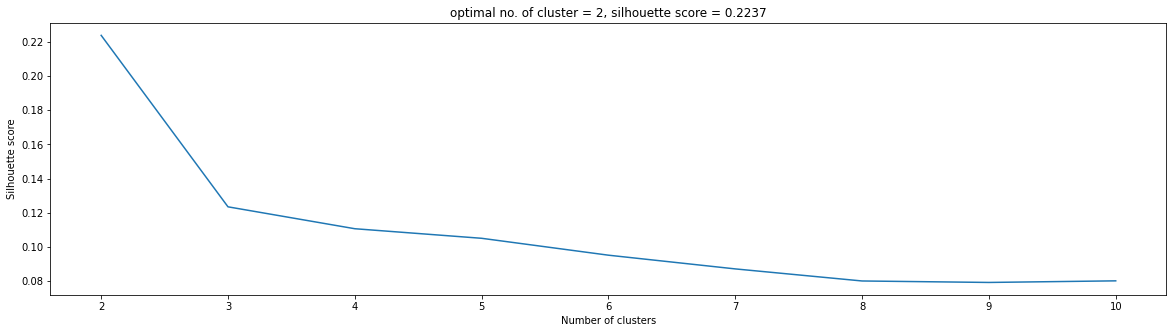

,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,PACE,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3A,OPP_FG3_PCT,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,ERA_0,ERA_1
0,0.873016,0.633663,0.296000,0.565517,0.402516,0.487310,0.779817,0.370968,0.772358,0.32,0.644068,0.288136,0.142857,0.333333,0.490741,0.770035,0.680162,0.752,0.675325,0.816667,0.268116,0.773333,0.32,0.509202,0.496774,0.332852,0.868687,0.956989,0.457317,0.260377,0.259615,0.703704,0.316176,0.437500,0.319249,0.297101,0.225410,0.729412,0.731884,0.728337,0.271663,0.726190,0.796089,0.302452,0.409091,0.319328,0.744681,0.147321,0.735385,0.264615,0.532951,0.467049,0.680162,0.319838,0.611940,0.391753,0.241611,0.156250,0.248588,0.204082,0.797468,0.186275,0.398058,0.31,0.741176,0.38,0.142857,0.288136,0.490741,0.333333,0.282258,0.655020,0.488133
1,0.484127,0.306931,0.453333,0.558621,0.534591,0.573604,0.605505,0.451613,0.154472,0.56,0.491525,0.627119,0.306122,0.379845,0.601852,0.554007,0.222672,0.168,0.116883,0.672222,0.239130,0.613333,0.56,0.398773,0.438710,0.144781,0.555556,0.688172,0.128049,0.211321,0.596154,0.802469,0.448529,0.433036,0.502347,0.289855,0.131148,0.611765,0.760870,0.543326,0.456674,0.428571,0.491620,0.495913,0.123377,0.554622,0.553191,0.187500,0.310769,0.689231,0.272206,0.727794,0.222672,0.777328,0.791045,0.340206,0.281879,0.343750,0.163842,0.153061,0.848101,0.333333,0.582524,0.56,0.611765,0.40,0.306122,0.627119,0.601852,0.379845,0.314516,0.574065,0.355550
2,0.325397,0.396040,0.160000,0.441379,0.710692,0.553299,0.550459,0.177419,0.414634,0.57,0.457627,0.898305,0.571429,0.573643,0.620370,0.466899,0.570850,0.312,0.376623,0.655556,0.050725,0.360000,0.57,0.306748,0.380645,0.362193,0.666667,0.677419,0.256098,0.233962,0.586538,0.592593,0.529412,0.553571,0.690141,0.449275,0.553279,0.717647,0.949275,0.829040,0.170960,0.705357,0.709497,0.179837,0.266234,0.756303,0.712766,0.254464,0.726154,0.273846,0.103152,0.896848,0.570850,0.429150,0.432836,0.597938,0.164430,0.562500,0.598870,0.326531,0.772152,0.323529,0.514563,0.58,0.717647,0.46,0.571429,0.898305,0.620370,0.573643,0.532258,0.750501,0.346629
3,0.158730,0.821782,0.117333,0.572414,0.754717,0.568528,0.394495,0.370968,0.813008,0.59,0.677966,0.457627,0.428571,0.751938,0.796296,0.658537,0.902834,0.528,0.792208,0.533333,0.384058,0.640000,0.59,0.558282,0.625806,0.293410,0.767677,0.408602,0.481707,0.516981,0.528846,0.493827,0.161765,0.232143,0.769953,0.347826,0.725410,0.741176,0.615942,0.864169,0.135831,0.764881,0.625698,0.136240,0.454545,0.714286,0.702128,0.477679,0.972308,0.027692,0.401146,0.598854,0.902834,0.097166,0.186567,0.381443,0.288591,0.304688,0.734463,0.377551,0.594937,0.147059,0.203883,0.35,0.741176,0.48,0.428571,0.457627,0.796296,0.751938,0.383065,0.822148,0.536663
4,0.396825,0.217822,0.378667,0.600000,0.528302,0.441624,0.633028,0.217742,0.292683,0.75,0.559322,0.745763,0.632653,0.682171,0.592593,0.404181,0.481781,0.136,0.246753,0.744444,0.072464,0.453333,0.75,0.312883,0.335484,0.333814,0.595960,0.698925,0.762195,0.369811,0.836538,0.790123,1.000000,0.611607,0.511737,0.463768,0.635246,0.741176,0.927536,0.608899,0.391101,0.473214,0.377095,0.455041,0.811688,0.563025,0.670213,0.437500,0.550769,0.449231,0.366762,0.633238,0.481781,0.518219,0.373134,0.597938,0.238255,0.359375,0.683616,0.102041,0.860759,0.235294,0.495146,0.73,0.741176,0.66,0.632653,0.745763,0.592593,0.682171,0.536290,0.749396,0.393507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [112]:
fit_seasonsimilarity = SeasonSimilarity(random_state=42, best_silh=True).fit(num_clean, plot_silh=True)
season_prepared = pd.DataFrame(fit_seasonsimilarity.transform(num_clean),
                               columns = fit_seasonsimilarity.get_feature_names_out())
season_prepared

### add to num_pipeline

In [113]:
# add to num_pipeline
num_pipeline.steps.append(
    ('season', SeasonSimilarity(random_state=42, n_clusters=2)) # choose 2 here instead of tuning as a hyperparameter
)

In [114]:
num_pipeline

Pipeline(steps=[('fixpf', FixPF(col_drop='PFD', col_replace='OPP_PF')),
                ('dropcols',
                 DropCols(cols_drop=['GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM',
                                     'FG3M', 'FTM', 'OPP_FGM', 'OPP_FG3M',
                                     'OPP_FTM', 'REB', 'PLUS_MINUS',
                                     'OFF_RATING', 'DEF_RATING', 'NET_RATING',
                                     'PACE_PER40', 'POSS', 'PIE'])),
                ('myminmaxscaler', MyMinMaxScaler()),
                ('season', SeasonSimilarity(n_clusters=2, random_state=42))])

### Alternative: agglomerative clustering

In [86]:
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram

# # create a custom transformer to cluster nba seasons into era
# class SeasonSimilarity2(BaseEstimator, TransformerMixin):
#   def __init__(self, n_clusters = 3, compute_distances = True):
#     self.n_clusters = n_clusters
#     self.compute_distances = compute_distances
  
#   def fit(self, X, y = None, sample_weight = None):
#     # group by season to get league average
#     X_season = X.groupby("SEASON").mean().sort_index()
#     self.feature_names_in_ = X.columns.values
#     self.index_names = X_season.sort_index().index.values
#     self.agg_cluster_ = AgglomerativeClustering(n_clusters=self.n_clusters, compute_distances=self.compute_distances)
#     self.agg_cluster_.fit(X_season)
#     return self
  
#   def transform(self, X):
#     X_season = X.groupby("SEASON").mean().sort_index()
#     X_cluster = pd.DataFrame(self.agg_cluster_.predict(X_season), index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
#     output = X[["SEASON"]].merge(X_cluster, how = "inner", on = "SEASON")
#     output.drop(columns = ["SEASON"], inplace = True)
#     output.index = X[["SEASON"]]
#     self.output_features = output.columns.values
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_features

#   def plot_dendrogram(self, **kwargs):
#     model = self.agg_cluster_
#     def create_plot(model, **kwargs):
#       # Create linkage matrix and then plot the dendrogram

#       # create the counts of samples under each node
#       counts = np.zeros(model.children_.shape[0])
#       n_samples = len(model.labels_)
#       for i, merge in enumerate(model.children_):
#           current_count = 0
#           for child_idx in merge:
#               if child_idx < n_samples:
#                   current_count += 1  # leaf node
#               else:
#                   current_count += counts[child_idx - n_samples]
#           counts[i] = current_count

#       linkage_matrix = np.column_stack(
#           [model.children_, model.distances_, counts]
#       )

#       # Plot the corresponding dendrogram
#       dendrogram(linkage_matrix, **kwargs)

#     create_plot(model, truncate_mode="level", p=20)
#     plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#     locs, labels = plt.xticks() 
#     plt.xticks(locs, [season['SEASON'].unique().to_list()[int(x.get_text())] for x in labels])
#     plt.show()

In [87]:
# agg_cluster = SeasonSimilarity2(n_clusters = 3, compute_distances=True).fit(season)
# agg_cluster.plot_dendrogram()

## (optional) Dimensionality reduction
- advantage
  - PCA can solve the axis orientation issue with decision tree
- disadvantage
  - information loss
  - harder to maintain pipeline as new data comes in
    - assume the current dataset is a random sampling of the underlying population, the PCA components should be stable
- considerations
  - let's not use PCA to allow interpretation of our feature
  - if we need to use decision tree, we can still use random forests or other ensemble methods on top of it
  - but random forest still assign high feature importance to highly correlated features (e.g. W_PCT, W, L)

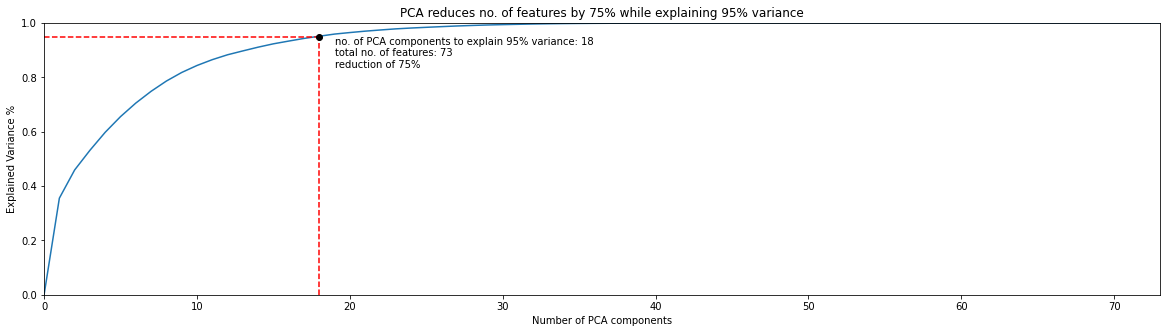

In [115]:
pca = PCA().fit(season_prepared)
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
# aim for 95% variance explained
target = np.argmax(pca_cumsum >= 0.95) + 1 # python starts counting at 0
plt.plot([*range(0,len(pca_cumsum)+1)], [0, *pca_cumsum])
plt.xlim(0,len(pca_cumsum))
plt.ylim(0,1)
plt.xlabel("Number of PCA components")
plt.ylabel("Explained Variance %")
plt.plot([target, target], [0, 0.95], 'r--')
plt.plot([0, target], [0.95, 0.95], 'r--')
plt.plot(target, 0.95, 'ko')
plt.annotate(f"no. of PCA components to explain 95% variance: {target}\n" + 
             f"total no. of features: {pca.n_features_in_}\n" + 
             f"reduction of {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%}", 
             [target+1, 0.95],
             ha = 'left',
             va = 'top')
plt.title(f"PCA reduces no. of features by {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%} while explaining 95% variance")
plt.show()

In [116]:
# don't add to data_preparation pipeline
# while PCA can help reduce no. of features significantly, reduce training time and avoid axis orientation issues in decision tree, 
# I want to keep features interpretable given the dataset is not too large

# data_preparation.steps.append(
#     ("pca", PCA(n_components=0.95))
# )

In [117]:
# print(f"target no. of features to explain 95% variance = {data_preparation.fit_transform(season).shape[1]}")

## Feature selection with lasso penalty
- use lasso penalty with logistic regression to select useful features
- threshold = hyperparameter to tune

In [118]:
selector = SelectFromModel(
    LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
    threshold=None # hyperparameter to tune
    ).fit(season_prepared, season_label.reshape(-1,))

In [119]:
# hyperparameter to tune
selector.threshold_

1e-05

In [120]:
# original training set
season.shape

(569, 96)

In [121]:
# reduced no. of features
selector.transform(season_prepared).shape

(569, 12)

In [122]:
# columns dropped
season_prepared.columns[~selector.get_support()]

Index(['FGA', 'FG3A', 'FG3_PCT', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL',
       'BLK', 'PFD', 'PTS', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT',
       'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'PACE',
       'PTS_OFF_TOV', 'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT',
       'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT', 'FTA_RATE',
       'OPP_EFG_PCT', 'OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
       'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM', 'PCT_UAST_3PM',
       'PCT_AST_FGM', 'PCT_UAST_FGM', 'OPP_FGA', 'OPP_FG3A', 'OPP_FG3_PCT',
       'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB', 'OPP_TOV', 'OPP_STL', 'OPP_BLK',
       'OPP_BLKA', 'OPP_PF', 'ERA_0', 'ERA_1'],
      dtype='object')

In [123]:
# columns retained
selector.get_feature_names_out()

array(['FG_PCT', 'FT_PCT', 'BLKA', 'PF', 'OPP_PTS_OFF_TOV', 'PCT_PTS_FT',
       'OPP_FG_PCT', 'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_PFD',
       'OPP_PTS'], dtype=object)

## Final pipeline = data_preparation



In [124]:
num_pipeline

Pipeline(steps=[('fixpf', FixPF(col_drop='PFD', col_replace='OPP_PF')),
                ('dropcols',
                 DropCols(cols_drop=['GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM',
                                     'FG3M', 'FTM', 'OPP_FGM', 'OPP_FG3M',
                                     'OPP_FTM', 'REB', 'PLUS_MINUS',
                                     'OFF_RATING', 'DEF_RATING', 'NET_RATING',
                                     'PACE_PER40', 'POSS', 'PIE'])),
                ('myminmaxscaler', MyMinMaxScaler()),
                ('season', SeasonSimilarity(n_clusters=2, random_state=42))])

In [125]:
data_preparation = make_pipeline(
    
    # data cleaning
    ColumnTransformer([
        # fixing columns / drop columns / quantile transform / clustering numeric columns
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
      ], 
      # drop remaining string columns such as TEAM_ID
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    ),

    # feature selection
    SelectFromModel(
      LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
      threshold=None # hyperparameter to tune
    )
)

In [126]:
data_preparation

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('fixpf',
                                                                   FixPF(col_drop='PFD',
                                                                         col_replace='OPP_PF')),
                                                                  ('dropcols',
                                                                   DropCols(cols_drop=['GP',
                                                                                       'W',
                                                                                       'L',
                                                                                       'W_PCT',
                                                                                       'MIN',
                                                                                       'FGM',
   

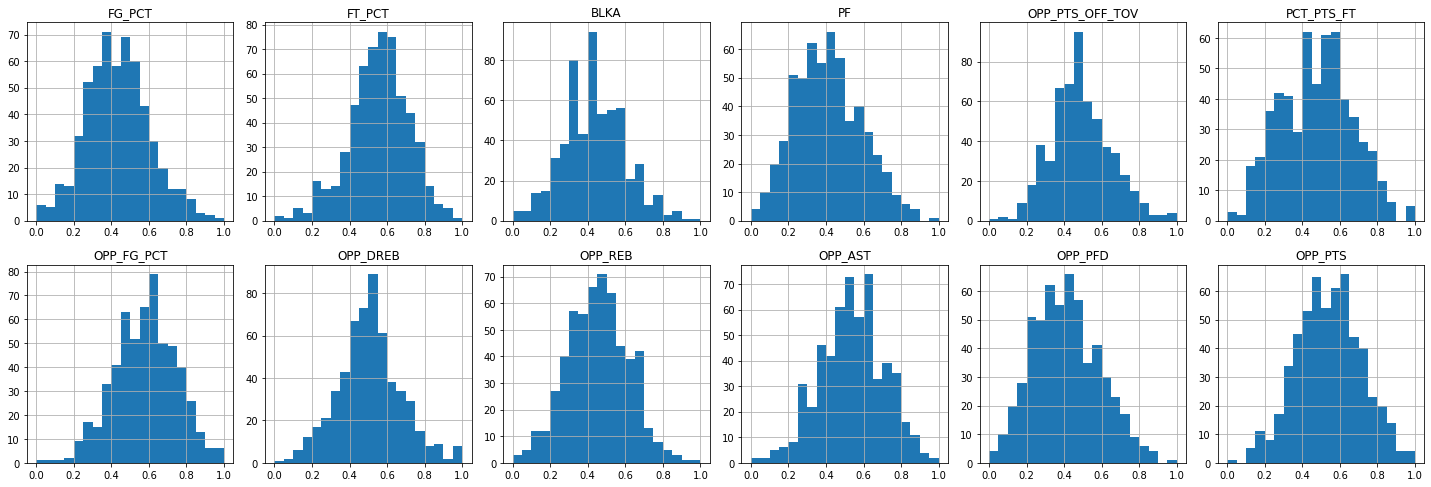

In [127]:
# plot distributions of each feature in X_train
plot_df = pd.DataFrame(data_preparation.fit_transform(season, season_label), 
                       columns = data_preparation.get_feature_names_out()).astype(float)
plot_df.hist(bins = 20, layout = (int(plot_df.shape[1] / 6) + 1, 6), figsize = (20,10))
plt.title("Distribution of each feature after cleaning")
plt.tight_layout()

# Shortlist promising models
- missing 
  - analyze most significant variables for each algorithm
  - analyze the type of errors the models make
    - what data would a human to use avoid these errors
  - perform a quick round of feature engineering and selection
  - shortlist models making different types of error

In [128]:
# create a list of models using standard hyperparameters to compare performance
dict_clf = {
    # 1) need predict_proba() for all classifiers such that we can use some ensemble methods later
    # 2) class imbalance in data
      # current method: rebalance class weight
      # alternative: sampling methods, e.g. oversampling, undersampling, SMOTE, ADA
      # medium article: 

    # "knn": KNeighborsClassifier(),
    "sgd": SGDClassifier(random_state=42, loss='log', penalty='elasticnet', class_weight='balanced'), # SGD solver for logistic regression
    # "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=10**4, class_weight='balanced'),
    "svc": SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced'), # SVC instead of LinearSVC for predict_proba()
    # "svc_poly": SVC(kernel='poly', random_state=42, probability=True, class_weight='balanced'), # probability=True for predict_proba()
    # "svc_rbf": SVC(kernel='rbf', random_state=42, probability=True, class_weight='balanced'), # probability=True for predict_proba()
    "tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "forest": RandomForestClassifier(random_state=42, class_weight='balanced_subsample'),
    # "gb": GradientBoostingClassifier(random_state=42),
    # "ada": AdaBoostClassifier(random_state=42),
    "xgb": XGBClassifier(random_state=42, scale_pos_weight=(season_label.size/season_label.sum() - 1)),
    "xgbrf": XGBRFClassifier(random_state=42, scale_pos_weight=(season_label.size/season_label.sum() - 1))
}

In [129]:
list_clf = []
AP_CVs = []
AP_train = []
list_precision = []
list_recall = []
list_thresholds = []

cv = 10

# fit each classification algorithm and calculate 10-fold CV AP
for key, item in tqdm(dict_clf.items()):
  print(key)
  # add estimator after data_preparation pipeline
  clf = Pipeline(
      data_preparation.steps + [(key, item)]
      ).fit(season, season_label)
  
  # cross validation score
  AP_CV = cross_val_score(clf, season, season_label, cv = cv, scoring = 'average_precision')
  # cross validation predict 
  try:
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba() method")
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'decision_function')
  
  precision, recall, thresholds = precision_recall_curve(season_label, y_scores)

  list_clf.append(key)
  AP_CVs.append(AP_CV)
  AP_train.append(average_precision_score(season_label, clf.predict_proba(season)[:,1]))
  list_precision.append(precision)
  list_recall.append(recall)
  list_thresholds.append(thresholds)

  0%|          | 0/6 [00:00<?, ?it/s]

sgd


 17%|█▋        | 1/6 [00:03<00:18,  3.68s/it]

svc


 33%|███▎      | 2/6 [00:08<00:16,  4.20s/it]

tree


 50%|█████     | 3/6 [00:14<00:15,  5.03s/it]

forest


 67%|██████▋   | 4/6 [00:23<00:13,  6.61s/it]

xgb


 83%|████████▎ | 5/6 [00:28<00:06,  6.18s/it]

xgbrf


100%|██████████| 6/6 [00:33<00:00,  5.60s/it]


In [130]:
# sort the models by AP but not other performance metrics dependent on decision threshold, e.g. precision and recall
mean_AP = [np.mean(AP) for AP in AP_CVs]
sd_AP = [np.std(AP) for AP in AP_CVs]
print("Models sorted by cross validation AP score")
for mean, sd, clf_name in sorted(zip(mean_AP, sd_AP, list_clf), reverse = True):
  print(f"CV AP: AVG {mean:0.4f} / SD {sd:0.4f} / {clf_name}")

Models sorted by cross validation AP score
CV AP: AVG 0.4371 / SD 0.2028 / sgd
CV AP: AVG 0.3712 / SD 0.1846 / svc
CV AP: AVG 0.3544 / SD 0.2011 / forest
CV AP: AVG 0.3479 / SD 0.2208 / xgbrf
CV AP: AVG 0.3453 / SD 0.2051 / xgb
CV AP: AVG 0.1805 / SD 0.2204 / tree


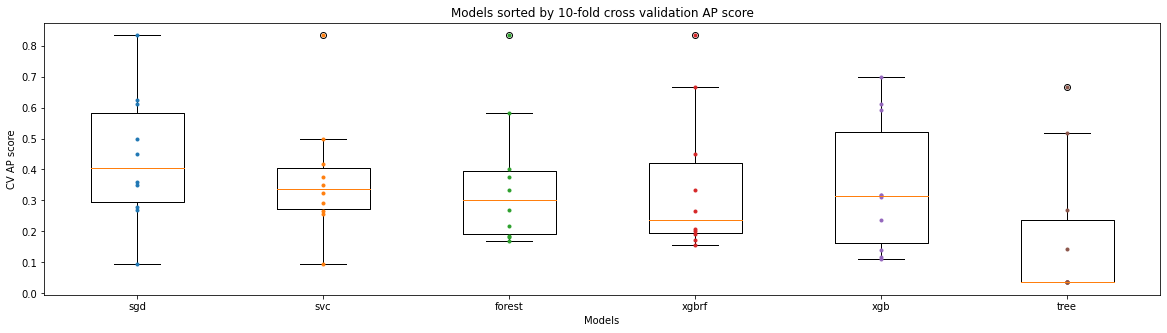

In [131]:
# sort the models and plot the spread of CV AP scores
mean_AP = [np.mean(AP) for AP in AP_CVs]
sorted_AP_CV = [i for _, i in [(mean_AP[i], AP_CVs[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_clf = [i for _, i in [(mean_AP[i], list_clf[i]) for i in np.argsort(mean_AP)[::-1]]]
sorted_AP_train = [i for _, i in [(mean_AP[i], AP_train[i]) for i in np.argsort(mean_AP)[::-1]]]
plt.boxplot(sorted_AP_CV, labels=sorted_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_AP_CV):
  plt.plot([i+1]*len(AP), AP, ".")
# plt.plot([*range(1,len(sorted_AP_CV)+1,1)], sorted_AP_train, "ks")
plt.title(f"Models sorted by {cv}-fold cross validation AP score")
plt.xlabel("Models")
plt.ylabel("CV AP score")
plt.show()

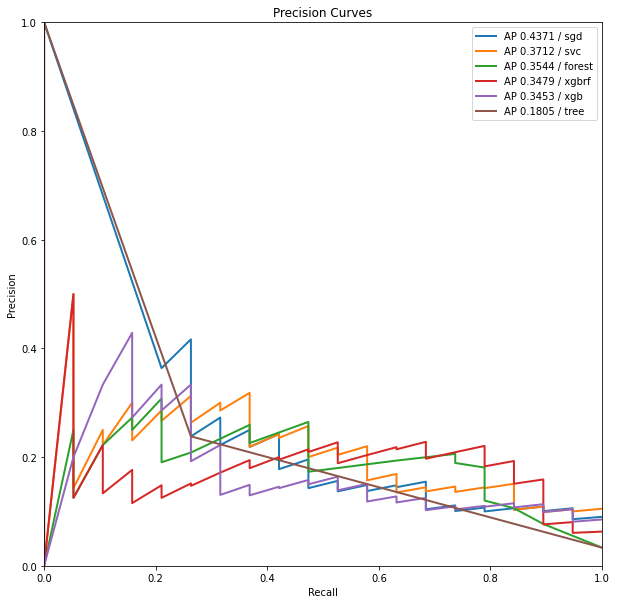

In [132]:
figure(figsize=(10, 10))
for AP, precision, recall, thresholds, clf_name in [(mean_AP[i], list_precision[i], list_recall[i], list_thresholds[i], list_clf[i]) for i in np.argsort(mean_AP)[::-1]]:
  # plt.plot(thresholds, precision[:-1], linewidth = 2, label = f"AP {AP:0.4f} / {clf_name}")
  plt.plot(recall, precision, linewidth = 2, label = f"AP {AP:0.4f} / {clf_name}")
# plt.plot([0,1], [0,1], 'k:', label = "AP 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Precision Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Fine-tune hyperparameters of shortlisted models with RandomizedSearchCV

In [133]:
# print top models to tune
top = 5
for name in sorted_clf[:top]:
  print(name, dict_clf[name])

sgd SGDClassifier(class_weight='balanced', loss='log', penalty='elasticnet',
              random_state=42)
svc SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)
forest RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
xgbrf XGBRFClassifier(random_state=42, scale_pos_weight=28.94736842105263)
xgb XGBClassifier(random_state=42, scale_pos_weight=28.94736842105263)


In [134]:
# testing reasonable range of hyperparameters before RandomizedSearchCV
# expon = False
# count = 1
# for i in range(1,10**2,10**1):
#   if expon:
#     count = count * i/10**20 / (i/10**22)
#     i = count
#   else:
#     i = i/10**2
#   full_pipeline = make_pipeline(
#       data_preparation,
#       AdaBoostClassifier(random_state=42, learning_rate=i)
#   )

#   full_pipeline.fit(season, season_label)
#   cv_score = cross_val_score(full_pipeline, season, season_label, cv = 5, scoring='roc_auc')
#   auc_train = roc_auc_score(season_label, full_pipeline.predict_proba(season)[:,1])
#   print(f"choice {i}, CV AUC {cv_score}")
#   print(f"mean AUC {np.mean(cv_score):0.4f}, std AUC {np.std(cv_score):0.4f} / train AUC {auc_train:0.4f}")
#   # print(full_pipeline.get_params().keys())
#   # plt.hist([np.log2(x) for x in loguniform(a=2**-2, b=2**2).rvs(size=10**6)])

In [135]:
# create a list of hyperparameters to tune for each shortlisted classifier
shortlisted_clfs = {
    "xgb": XGBClassifier(random_state=42, scale_pos_weight=(season_label.size/season_label.sum() - 1)),
    # "ada": AdaBoostClassifier(random_state=42),
    # "gb": GradientBoostingClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42, class_weight='balanced_subsample'),
    "xgbrf": XGBRFClassifier(random_state=42, scale_pos_weight=(season_label.size/season_label.sum() - 1)),
    # "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=10**4, class_weight='balanced'),
    "svc": SVC(kernel='linear', probability=True, max_iter=10**5, random_state=42),
    # "svc_poly": SVC(kernel='poly', probability=True, random_state=42, class_weight='balanced'),
    # "svc_rbf": SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    "sgd": SGDClassifier(random_state=42, penalty='elasticnet', loss='log', class_weight='balanced')
    
}

param_grids = {
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    "xgb": {
        "xgb__gamma": uniform(loc = 0, scale = 10),
        "xgb__reg_alpha": uniform(loc = 0, scale = 10),
        "xgb__reg_gamma": uniform(loc = 0, scale = 10),
        "xgb__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgb__max_depth": randint(low = 1, high = 5),
        "xgb__min_child_weight": randint(low = 1, high = 30),
    },

    "xgbrf": {
        "xgbrf__gamma": uniform(loc = 0, scale = 10),
        "xgbrf__reg_alpha": uniform(loc = 0, scale = 10),
        "xgbrf__reg_gamma": uniform(loc = 0, scale = 10),
        "xgbrf__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgbrf__max_depth": randint(low = 1, high = 5),
        "xgbrf__min_child_weight": randint(low = 1, high = 30),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
    "forest": {
        "forest__max_depth": randint(low = 3, high = 5),
        "forest__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        # "forest__min_samples_leaf": uniform(loc = 0.01, scale = 0.2)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier
    "ada": {
        "ada__learning_rate": loguniform(a = 10**-2, b = 10**0),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboost#sklearn.ensemble.GradientBoostingClassifier
    "gb": {
        "gb__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        "gb__max_depth": randint(low = 1, high = 5),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    "logistic": {
        "logistic__C": loguniform(a = 10**-3, b = 10**-1),
        "logistic__l1_ratio": uniform(loc = 0, scale = 1),
    },

     # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc_poly": {
        "svc_poly__C": loguniform(a = 10**-20, b = 10**1)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc": {
        "svc__C": loguniform(a = 10**-20, b = 10**1)
    },


    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc_rbf": {
        "svc_rbf__C": loguniform(a = 10**-20, b = 10**1)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier
    "sgd": {
        "sgd__l1_ratio": uniform(loc = 0, scale = 1),
        "sgd__alpha": loguniform(a = 10**-3, b = 10**-1),
        "sgd__learning_rate": ['optimal', 'adaptive'],
        "sgd__eta0": loguniform(a = 10**-3, b = 10**-1)
    }
    
}

## Issue with best_estimator_
sklearn returns best_estimator_ at best_index_ = highest mean_test_score 
- but if there is a tie based on mean_test_score, sklearn does not return the one with the lowest std_test_score
- https://github.com/scikit-learn/scikit-learn/blob/db8d67c6a10ef37bf58088e414bbe8a7f7160c60/sklearn/model_selection/_search.py#L1260

In [136]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
random_clfs = []
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

for clf_name, clf in tqdm(shortlisted_clfs.items()):

  full_pipeline = Pipeline(
      data_preparation.steps + [(clf_name, clf)]
      )

  print(clf_name)
  print(clf)
  
  param_grid = copy.deepcopy(param_grids[clf_name])
  # tune C for inverse of regularization strength in lasso penalty for feature selection in data_prepartion pipeline
  param_grid["selectfrommodel__estimator__C"] = loguniform(a = 10**0, b = 10**1)
  
  print(param_grid)

  random_search = RandomizedSearchCV(full_pipeline, 
                                    param_grid, 
                                    cv = 10, 
                                    n_iter = 100, 
                                    scoring = "average_precision",
                                    random_state = 42,
                                    n_jobs = -1,
                                    error_score = 'raise')

  random_search.fit(season, season_label)
  random_clfs.append(random_search)

  print(f"\nbest_score: {random_search.best_score_}")
  print(f"best_params: {random_search.best_params_}")
  # print(pd.DataFrame(random_search.cv_results_))
  print(f'{clf_name} class balanced AP {random_search.best_estimator_.steps[-1][0]} dumped {current_time}')
  dump(random_search, f'{clf_name}_tuned_AP_class_balanced_{current_time}.joblib') 

  0%|          | 0/5 [00:00<?, ?it/s]

xgb
XGBClassifier(random_state=42, scale_pos_weight=28.94736842105263)
{'xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b938cdd0>, 'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b71be490>, 'xgb__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b93a7f50>, 'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8969650>, 'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8969950>, 'xgb__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8969390>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b71be9d0>}


 20%|██        | 1/5 [01:50<07:20, 110.10s/it]


best_score: 0.5075222816399287
best_params: {'selectfrommodel__estimator__C': 9.165845837596681, 'xgb__gamma': 3.748705795237041, 'xgb__learning_rate': 0.29571208628186074, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__reg_alpha': 2.235958385194526, 'xgb__reg_gamma': 9.632225394406113}
xgb class balanced AP xgb dumped 20220918_154133
forest
RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
{'forest__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b71be690>, 'forest__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8d89cd0>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b2b37210>}


 40%|████      | 2/5 [05:35<08:53, 177.72s/it]


best_score: 0.5558682880586905
best_params: {'forest__max_depth': 4, 'forest__min_samples_split': 0.10026018849765791, 'selectfrommodel__estimator__C': 2.252002437952502}
forest class balanced AP forest dumped 20220918_154133
xgbrf
XGBRFClassifier(random_state=42, scale_pos_weight=28.94736842105263)
{'xgbrf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8e25c50>, 'xgbrf__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8e25350>, 'xgbrf__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8e25b90>, 'xgbrf__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8e25c10>, 'xgbrf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8e25b10>, 'xgbrf__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41ba517d10>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b8e25610>}


 60%|██████    | 3/5 [07:11<04:40, 140.34s/it]


best_score: 0.5639087301587302
best_params: {'selectfrommodel__estimator__C': 2.908696477239765, 'xgbrf__gamma': 3.533522280260528, 'xgbrf__learning_rate': 0.5936561118508721, 'xgbrf__max_depth': 4, 'xgbrf__min_child_weight': 5, 'xgbrf__reg_alpha': 9.743948076661665, 'xgbrf__reg_gamma': 9.86210744479603}
xgbrf class balanced AP xgbrf dumped 20220918_154133
svc
SVC(kernel='linear', max_iter=100000, probability=True, random_state=42)
{'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b904a090>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b721f8d0>}


 80%|████████  | 4/5 [08:24<01:54, 114.05s/it]


best_score: 0.5115629202239109
best_params: {'selectfrommodel__estimator__C': 3.142306225908965, 'svc__C': 2.081826373892931e-14}
svc class balanced AP svc dumped 20220918_154133
sgd
SGDClassifier(class_weight='balanced', loss='log', penalty='elasticnet',
              random_state=42)
{'sgd__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41c4163590>, 'sgd__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b86d17d0>, 'sgd__learning_rate': ['optimal', 'adaptive'], 'sgd__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41b86cd850>, 'selectfrommodel__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f41ba553450>}


100%|██████████| 5/5 [09:35<00:00, 115.12s/it]


best_score: 0.5226184640522875
best_params: {'selectfrommodel__estimator__C': 2.744568806348263, 'sgd__alpha': 0.02208270498902507, 'sgd__eta0': 0.004532161058999155, 'sgd__l1_ratio': 0.1550416167277442, 'sgd__learning_rate': 'adaptive'}
sgd class balanced AP sgd dumped 20220918_154133


## Check model performance after hyperparameter tuning

In [60]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
tuned_models = {}
time_list = []
time_diff = []
match_pattern = '_tuned_AP_class_balanced_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "SMOTE AP loaded")

xgb SMOTE AP loaded
forest SMOTE AP loaded
xgbrf SMOTE AP loaded
svc SMOTE AP loaded
sgd SMOTE AP loaded


In [148]:
# pull the CV AP results from RandomizedSearchCV
tuned_AP = []
for clf_name, model in tuned_models.items():
  # tuned_AP.append(cross_val_score(model.best_estimator_, season, season_label, cv = 10, scoring='average_precision'))
  cv_AP_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_AP.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_AP_colindex].values)

In [149]:
from sklearn.metrics import average_precision_score
# sort the models and plot the spread of CV AP scores
mean_tuned_AP = [np.mean(auc) for auc in tuned_AP]
mean_train_AP = [average_precision_score(season_label, model.best_estimator_.predict_proba(season)[:,1]) for _, model in tuned_models.items()]
sorted_tuned_AP = [i for _, i in sorted(zip(mean_tuned_AP, tuned_AP), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_AP, tuned_models.keys()), reverse = True)]
sorted_train_AP = [i for _, i in sorted(zip(mean_tuned_AP, mean_train_AP), reverse = True)]

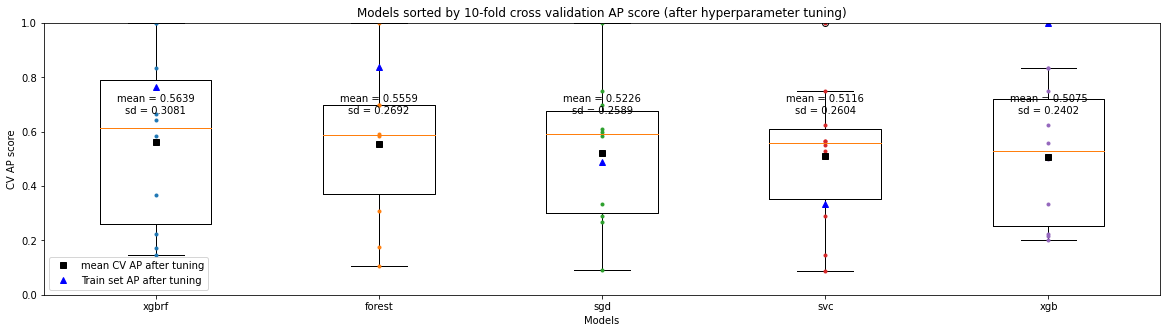

In [150]:
plt.boxplot(sorted_tuned_AP, labels=sorted_tuned_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_tuned_AP):
  plt.plot([i+1]*len(AP), AP, ".")
  plt.annotate(f"mean = {np.mean(AP):0.4f}\nsd = {np.std(AP):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted(mean_tuned_AP, reverse=True), 
         "ks", label = 'mean CV AP after tuning')
plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted_train_AP, 
         "b^", label = 'Train set AP after tuning')
# plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], [mean_AP[list_clf.index(x)] for x in sorted_tuned_clf], 
#          "k^", label = 'mean CV AP before tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AP score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV AP score")
plt.show()

In [151]:
list_clf = []
auc_CVs = []
auc_train = []
list_precision = []
list_recall = []
list_thresholds = []

cv = 10

# fit each classification algorithm and calculate 10-fold CV AUC
for key, item in tqdm(tuned_models.items()):
  clf = item.best_estimator_.fit(season, season_label)
  auc_CV = cross_val_score(clf, season, season_label, cv = cv, scoring = 'roc_auc')
  try:
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba() method")
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'decision_function')
  
  precision, recall, thresholds = precision_recall_curve(season_label, y_scores)

  list_clf.append(key)
  auc_CVs.append(auc_CV)
  auc_train.append(roc_auc_score(season_label, clf.predict_proba(season)[:,1]))
  list_precision.append(precision)
  list_recall.append(recall)
  list_thresholds.append(thresholds)

100%|██████████| 5/5 [00:34<00:00,  6.83s/it]


In [152]:
sorted_tuned_AUC = [i for _, i in sorted(zip(mean_tuned_AP, auc_CVs), reverse = True)]
sorted_train_AUC = [i for _, i in sorted(zip(mean_tuned_AP, auc_train), reverse = True)]

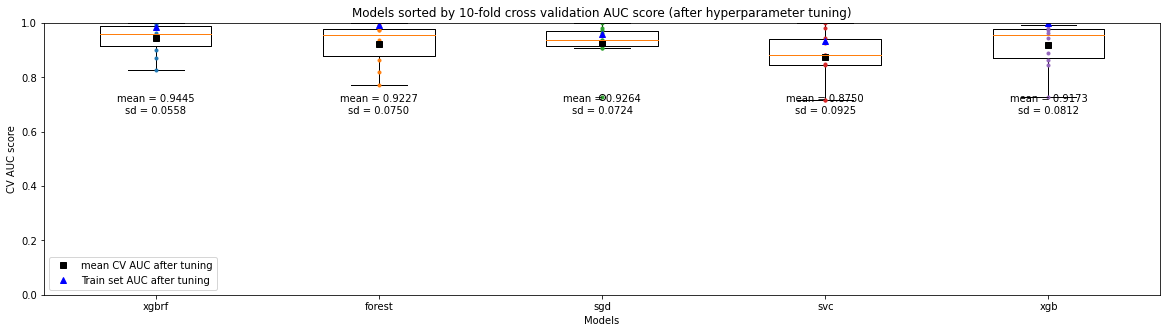

In [153]:
plt.boxplot(sorted_tuned_AUC, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, AUC in enumerate(sorted_tuned_AUC):
  plt.plot([i+1]*len(AUC), AUC, ".")
  plt.annotate(f"mean = {np.mean(AUC):0.4f}\nsd = {np.std(AUC):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [np.mean(x) for x in sorted_tuned_AUC], 
         "ks", label = 'mean CV AUC after tuning')
plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], sorted_train_AUC, 
         "b^", label = 'Train set AUC after tuning')
# plt.plot([*range(1,len(sorted_tuned_AUC)+1,1)], [mean_AUC[list_clf.index(x)] for x in list_clf], 
#          "k^", label = 'mean CV AUC before tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV AUC score")
plt.show()

In [164]:
idx = list_clf.index("sgd")

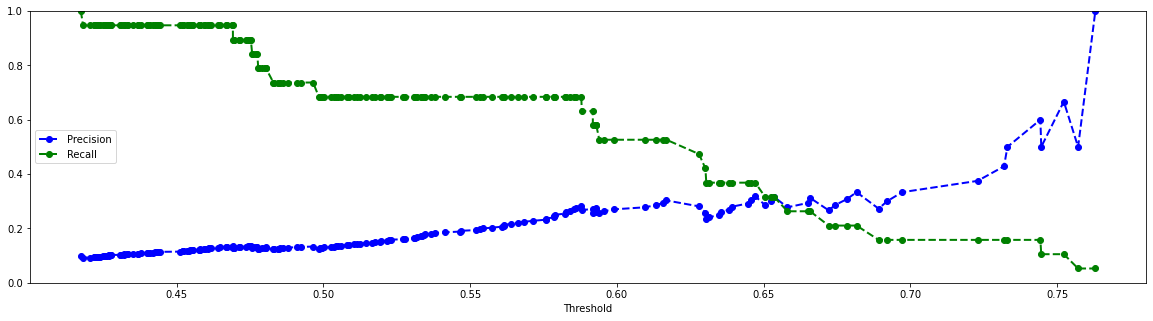

In [165]:
precisions = list_precision[idx]
recalls = list_recall[idx]
thresholds = list_thresholds[idx]
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
# plt.axhline(0.9, c='k')
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.legend()
plt.show()

# Ensemble methods
- Combining tuned models with ensemble learning didn't give a better CV result 

In [ ]:
# get performance from adaboost and bagging ensemble methods on each tuned model
single_clf_ensemble_models = {
    "Adaboost": AdaBoostClassifier(random_state = 42),
    "Bagging": BaggingClassifier(random_state = 42, n_estimators=50)
}

for ensemble_key, ensemble_model in single_clf_ensemble_models.items():
  for model in sorted_tuned_clf:
    ensemble_model.base_estimator = tuned_models[model].best_estimator_.steps[1][1]
    ensemble_pipeline = make_pipeline(
        data_preparation,
        ensemble_model
    )
    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 10, scoring = 'roc_auc')
    print(f"mean AUC = {np.mean(cv_score):0.4f}, std AUC = {np.std(cv_score):0.4f}, {ensemble_key} {model}")

mean AUC = 0.5000, std AUC = 0.0000, Adaboost logistic
mean AUC = 0.5000, std AUC = 0.0000, Adaboost sgd
mean AUC = 0.5000, std AUC = 0.0000, Adaboost xgbrf
mean AUC = 0.9218, std AUC = 0.0709, Adaboost forest
mean AUC = 0.5000, std AUC = 0.0000, Adaboost xgb


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

mean AUC = 0.9318, std AUC = 0.0405, Bagging logistic
mean AUC = 0.9355, std AUC = 0.0546, Bagging sgd
mean AUC = 0.9191, std AUC = 0.0614, Bagging xgbrf
mean AUC = 0.9109, std AUC = 0.0702, Bagging forest
mean AUC = 0.9045, std AUC = 0.0852, Bagging xgb


In [ ]:
# get performance from voting and stacking ensemble methods on an increasing basket of tuned models
multiple_clf_ensemble_models = {
    "Voting": VotingClassifier(voting = 'soft', estimators = []),
    "Stacking": StackingClassifier(cv = 10, final_estimator=RandomForestClassifier(random_state=43), estimators = [])
}

for ensemble_key, ensemble_model in multiple_clf_ensemble_models.items():
  for i in range(1,len(tuned_models)):
    ensemble_model.estimators = [(model, tuned_models[model].best_estimator_.steps[1][1]) for model in sorted_tuned_clf[:(i+1)]]
    ensemble_pipeline = make_pipeline(
        data_preparation,
        ensemble_model
    )
    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 10, scoring = 'roc_auc')
    print(f"mean AUC = {np.mean(cv_score):0.4f}, std AUC = {np.std(cv_score):0.4f}, {ensemble_key} {[model for model in sorted_tuned_clf[:(i+1)]]}")

mean AUC = 0.9382, std AUC = 0.0511, Voting ['logistic', 'sgd']
mean AUC = 0.9382, std AUC = 0.0517, Voting ['logistic', 'sgd', 'xgbrf']
mean AUC = 0.9373, std AUC = 0.0505, Voting ['logistic', 'sgd', 'xgbrf', 'forest']
mean AUC = 0.9355, std AUC = 0.0610, Voting ['logistic', 'sgd', 'xgbrf', 'forest', 'xgb']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

mean AUC = 0.8923, std AUC = 0.0857, Stacking ['logistic', 'sgd']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

mean AUC = 0.9055, std AUC = 0.0832, Stacking ['logistic', 'sgd', 'xgbrf']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

mean AUC = 0.9068, std AUC = 0.0815, Stacking ['logistic', 'sgd', 'xgbrf', 'forest']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

mean AUC = 0.9345, std AUC = 0.0300, Stacking ['logistic', 'sgd', 'xgbrf', 'forest', 'xgb']
